In [1]:
from enum import auto, StrEnum

from urllib.parse import quote
from urllib.request import urlopen
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.rcParams["figure.figsize"] = (10, 10)


class Preset(StrEnum):
    duel = auto()
    team = auto()
    ffa = auto()
    all = auto()

PRESET = Preset.team

In [2]:
def get_data(url: str):
    with urlopen(url) as response:
        source = response.read().decode("utf-8")
    data = json.loads(source)
    return data

In [3]:
leaderboards = get_data("https://api.bar-rts.com/leaderboards")

In [4]:
team_leaderboards_df = pd.json_normalize(leaderboards[PRESET.name])

In [5]:
team_leaderboards_df

age   colour                      icon              name     rating
0     0  #660000             fa-solid fa-c       [TZN]Clyret  54.815066
1     0  #666666          fa-solid fa-user        [KoN]VodKa  49.126632
2     0  #00aa66   fa-solid fa-code-commit            Raghna  45.136432
3     0  #666666          fa-solid fa-user        MomsBoyToy  44.159541
4     2  #666666          fa-solid fa-user       XFactorLive  43.679861
5     0  #660000             fa-solid fa-c        Zerpiederp  43.164498
6     0  #660000             fa-solid fa-c          [Fx]ShoX  42.969815
7     0  #666666          fa-solid fa-user             goopy  41.893745
8     0  #666666          fa-solid fa-user              [8D]  41.755766
9     0  #660000             fa-solid fa-c           Dankest  41.614807
10    0  #660066    fa-solid fa-user-robot        HellsHound  40.560265
11    0  #666666          fa-solid fa-user            Malady  39.241063
12    0  #666666          fa-solid fa-user            Raikoh  37.275452
13    0  #666666          fa-solid fa-user            Snoopa  36.892106
14    0  #666666          fa-solid fa-user         BIG_DOLFY  36.695755
15    0  #666666          fa-solid fa-user             Flash  36.691545
16    0  #666666          fa-solid fa-user          SadPanda  36.684524
17    0  #666666          fa-solid fa-user  Skymirrh[BAB]Lob  36.389796
18    0  #666666          fa-solid fa-user    Fatalebaguette  35.972569
19    0  #666666          fa-solid fa-user            Daymus  35.615675
20    0  #666666          fa-solid fa-user          Dave[tB]  35.565568
21    7  #000066             fa-solid fa-a             MAdka  35.220746
22    0  #AA6600     fa-solid fa-drumstick         PathOfBFR  35.104085
23    3  #666666          fa-solid fa-user     [CMG]Operator  34.930492
24    0  #666666          fa-solid fa-user       [LOB]Choice  34.628780
25    0  #666666          fa-solid fa-user       Lostdeadman  34.357182
26   14  #666666          fa-solid fa-user           oli2k00  33.737883
27    0  #666666          fa-solid fa-user        Shadhunter  33.612502
28    2  #666666          fa-solid fa-user         ElmerFudd  33.094010
29    0  #666666          fa-solid fa-user      starcraftman  33.022127

In [6]:
# Get the players replays metadata
def get_match_data(user: str, preset: Preset = Preset.all):
    # Depending on the preset, the API returns different data.json
    # The preset uses the following format: &preset=duel%2Cffa%2Cteam
    # duel%2Cffa%2Cteam is the same as duel,ffa,team

    if preset == Preset.all:
        preset = "&preset=duel%2Cffa%2Cteam"
    else:
        preset = f"&preset={preset.name}"

    uri = f"https://api.bar-rts.com/replays?page=1&limit=999{preset}&hasBots=false&endedNormally=true&players="

    data = get_data(f"{uri}{quote(user)}")

    # Get the winning team and count the number of wins
    match = {}
    matches = []

    for game in data["data"]:
        if game["Map"]["fileName"] is not None:
            for team in game["AllyTeams"]:
                for player in team["Players"]:
                    if player["name"] == user:
                        match = {
                            **match,
                            **{
                                "id": game["id"],
                                "name": player["name"],
                                "winningTeam": team["winningTeam"],
                                "Map.fileName": game["Map"]["fileName"]
                                + "_"
                                + str(len(team["Players"]))
                                + "v"
                                + str(len(team["Players"])),
                                "Map.scriptName": game["Map"]["scriptName"],
                                "durationMs": game["durationMs"],
                                "startTime": game["startTime"],
                            },
                        }
                        matches.append(match)

    matches_df = pd.json_normalize(matches)
    return matches_df

In [7]:
# Get the win rate for each map
def get_win_rate(user: str, min_games: int = 5):
    df = get_match_data(user, PRESET)
    win_rate = (
        df.groupby(["Map.fileName"])
        .agg({"winningTeam": ["mean", "count"]})["winningTeam"]
        .query(f"count > {str(min_games)}")
        .sort_values([("mean"), ("count")], ascending=True)
    )
    return win_rate

In [8]:
# Use win_rate and plot the winning % for each map with the number of
# games played with horizontal bars and subdivide the bars by the winning team
# with minor locator for the x axis. Color by count and winningTeam.

# Set the x axis minor locator to 5 and major locator to 10


def plot_win_rate(user: str):
    win_rate = get_win_rate(user)
    if win_rate.empty:
        print(f"{user} has not played enough games")
        return

    _, (ax1, ax2) = plt.subplots(1, 2, sharey="all", figsize=(12, 6))

    bars = ax1.barh(
        y=win_rate.index,
        width=win_rate["mean"],
        alpha=0.75,
    )
    ax1.bar_label(bars, fmt="{:.0%}", label_type="center")
    ax1.xaxis.set_minor_locator(ticker.MultipleLocator(0.05))
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax1.grid(which="minor", axis="x", linestyle="--")
    ax1.grid(which="major", axis="x", linestyle="-")
    ax1.set_xlabel("Winning %")
    ax1.set_ylabel("Map")
    ax1.set_xlim(0, 1)
    ax1.set_title(f"[{PRESET.name} games]{user} Winning % by Map")

    ax1.set_axisbelow(True)

    bars = ax2.barh(
        y=win_rate.index,
        width=win_rate["count"],
        alpha=0.75,
    )

    ax2.bar_label(bars, label_type="center")
    ax2.xaxis.set_minor_locator(ticker.MultipleLocator(5))
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax2.grid(which="minor", axis="x", linestyle="--")
    ax2.grid(which="major", axis="x", linestyle="-")
    ax2.set_xlabel("Games")
    ax2.set_title(f"{user} No. games by Map")

    plt.subplots_adjust(wspace=0, hspace=0)

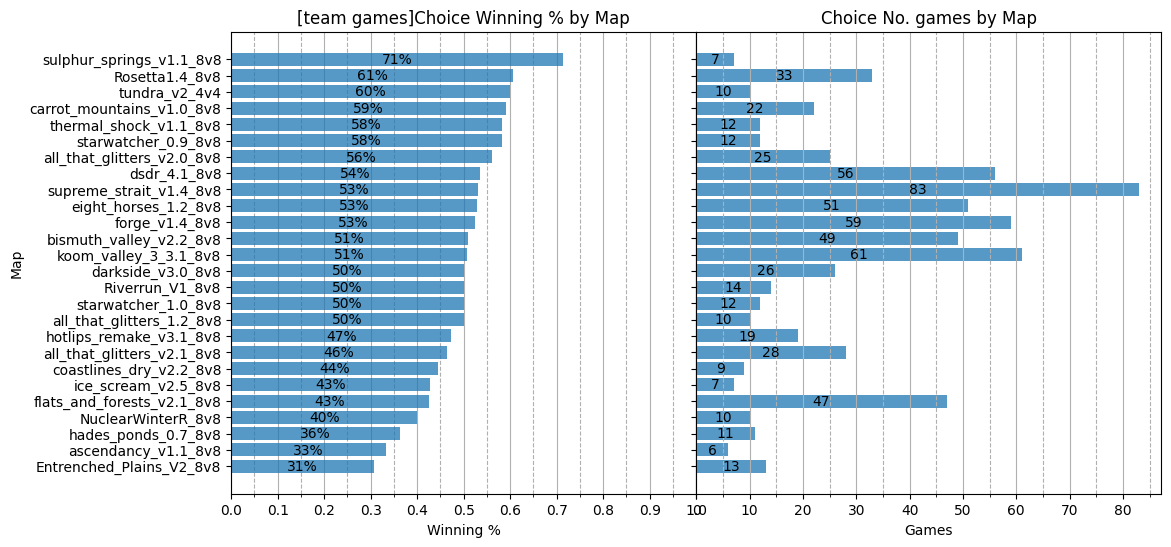

In [12]:
plot_win_rate("Choice")
plt.show()

/tmp/ipykernel_31223/421834099.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, (ax1, ax2) = plt.subplots(1, 2, sharey="all", figsize=(12, 6))


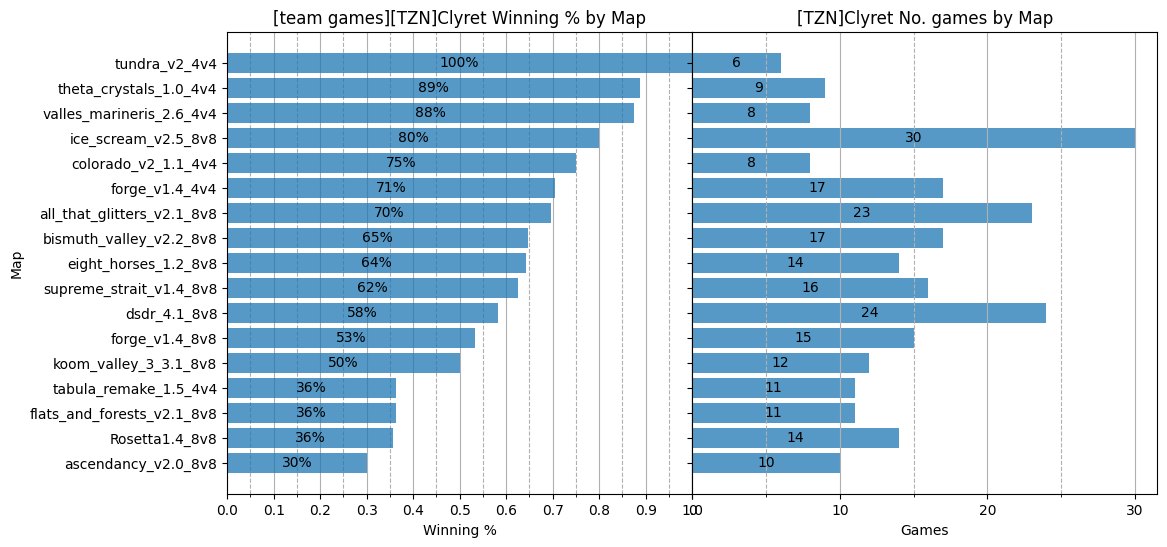

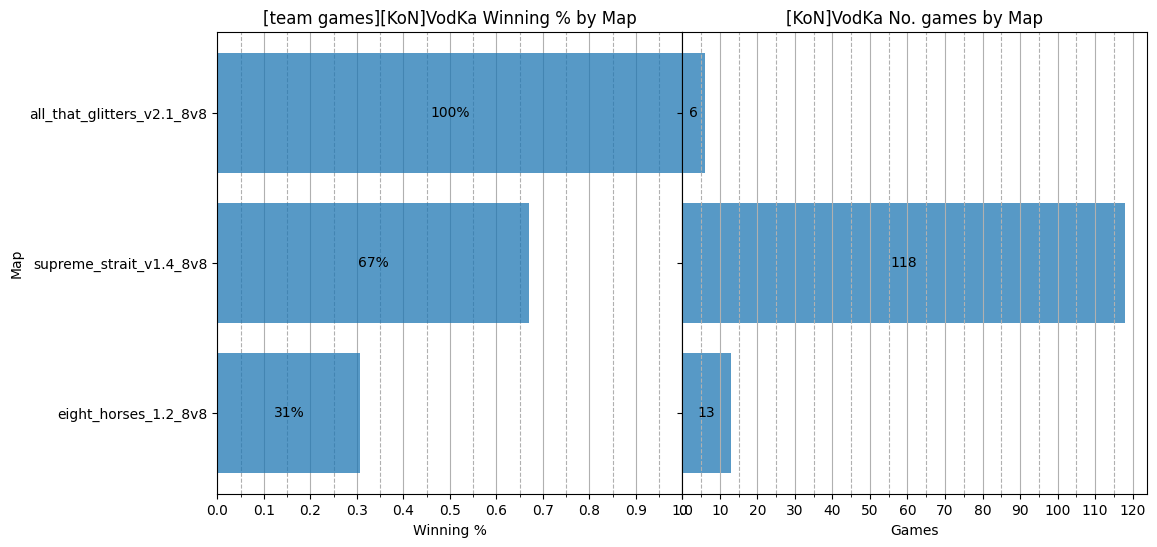

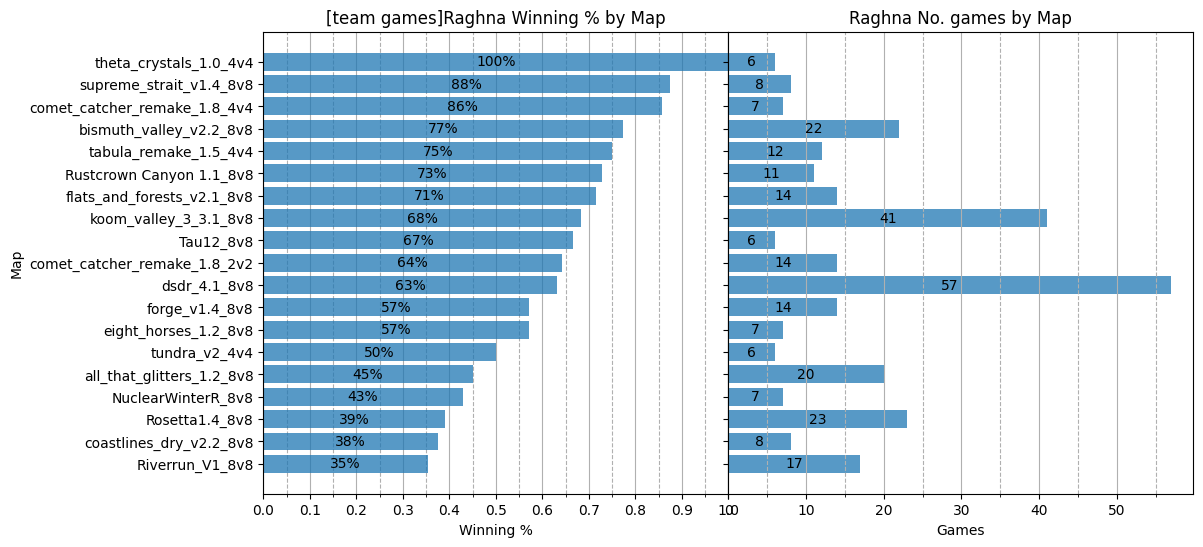

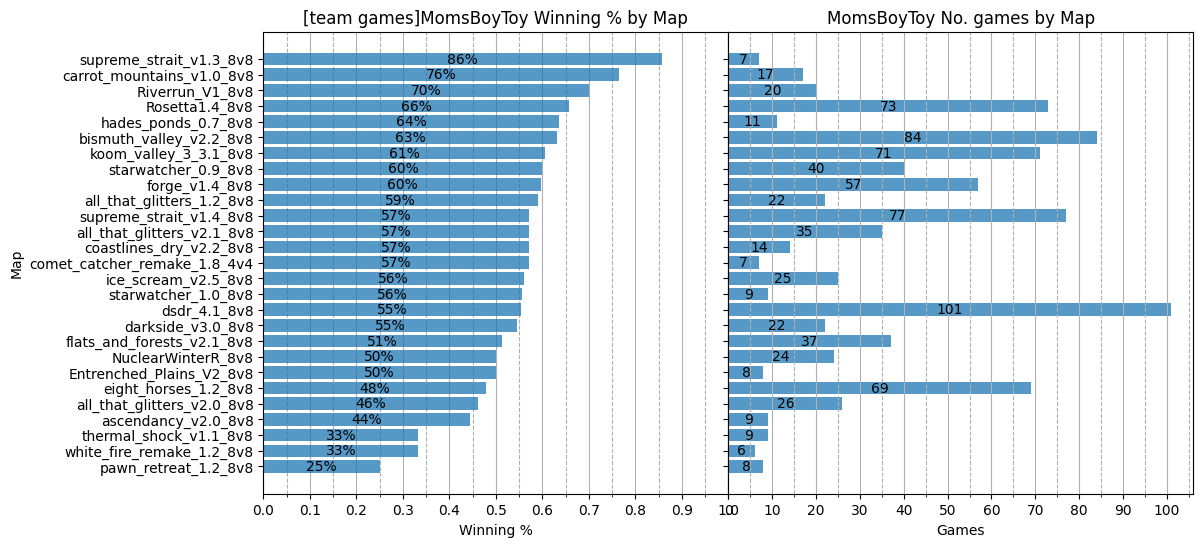

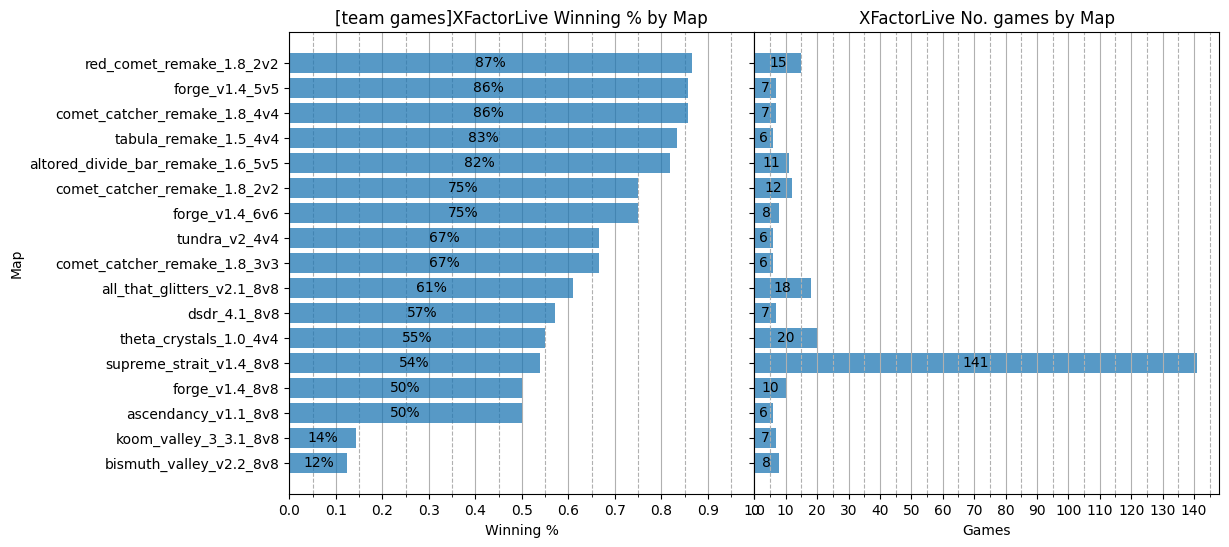

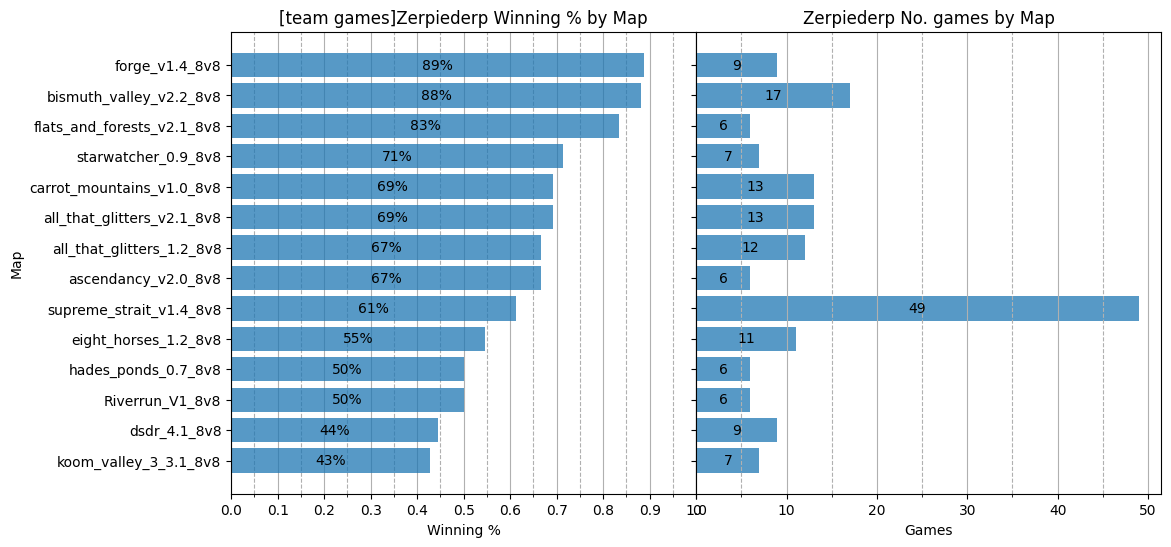

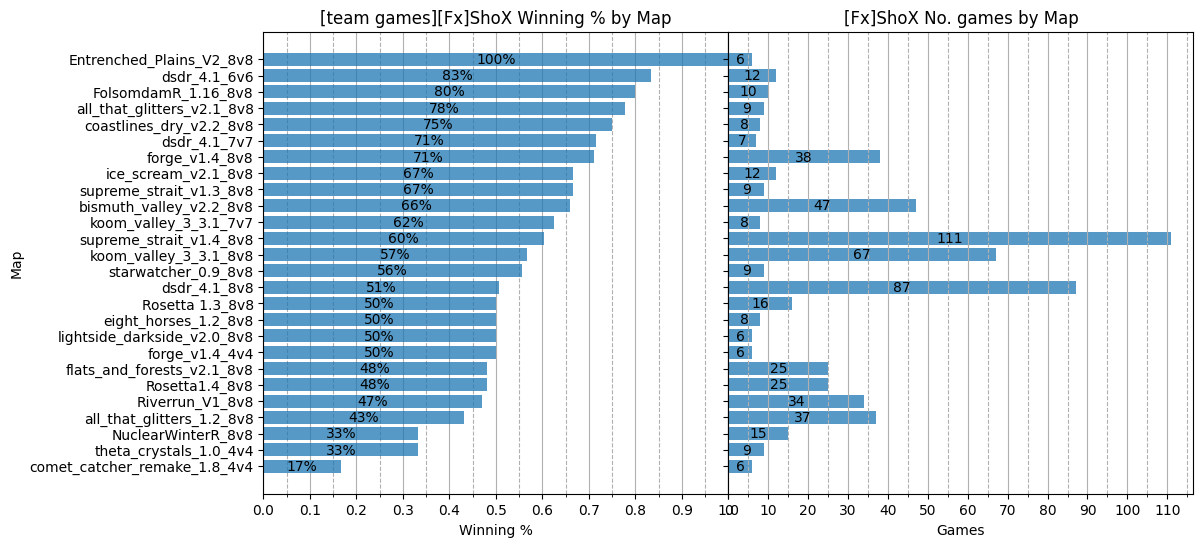

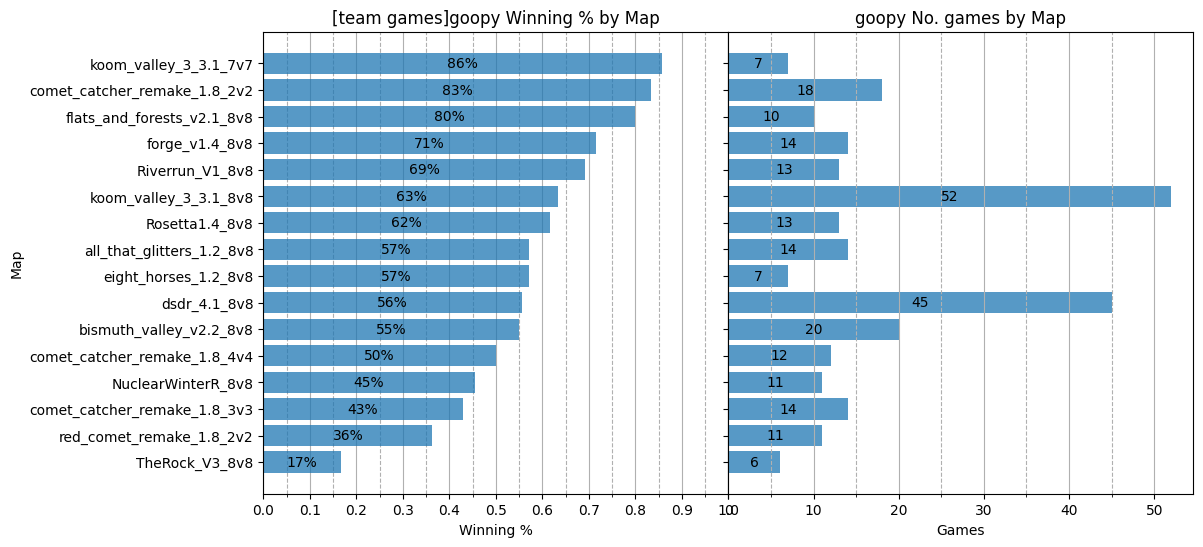

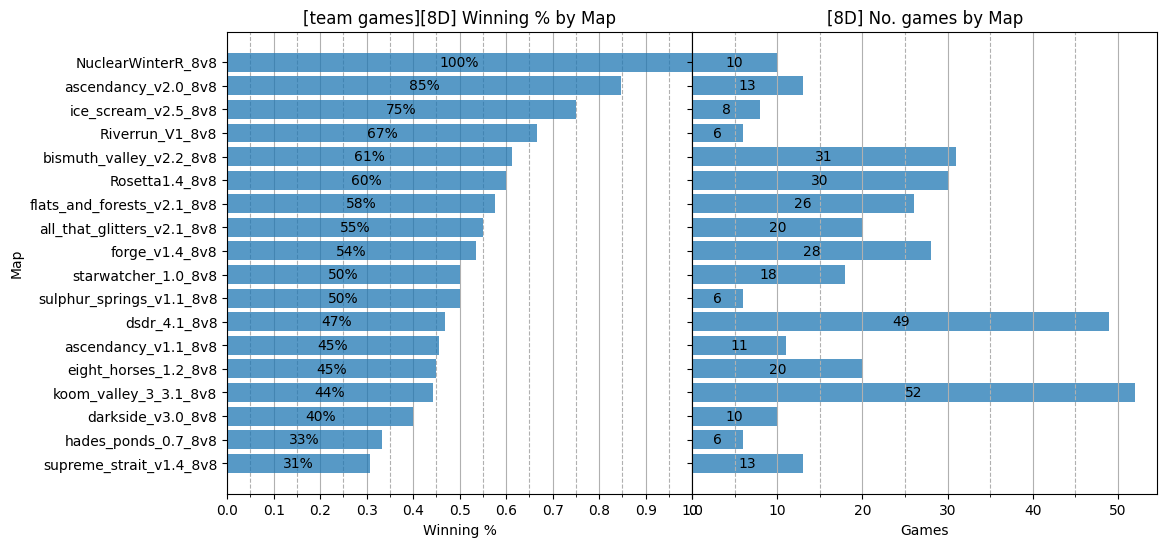

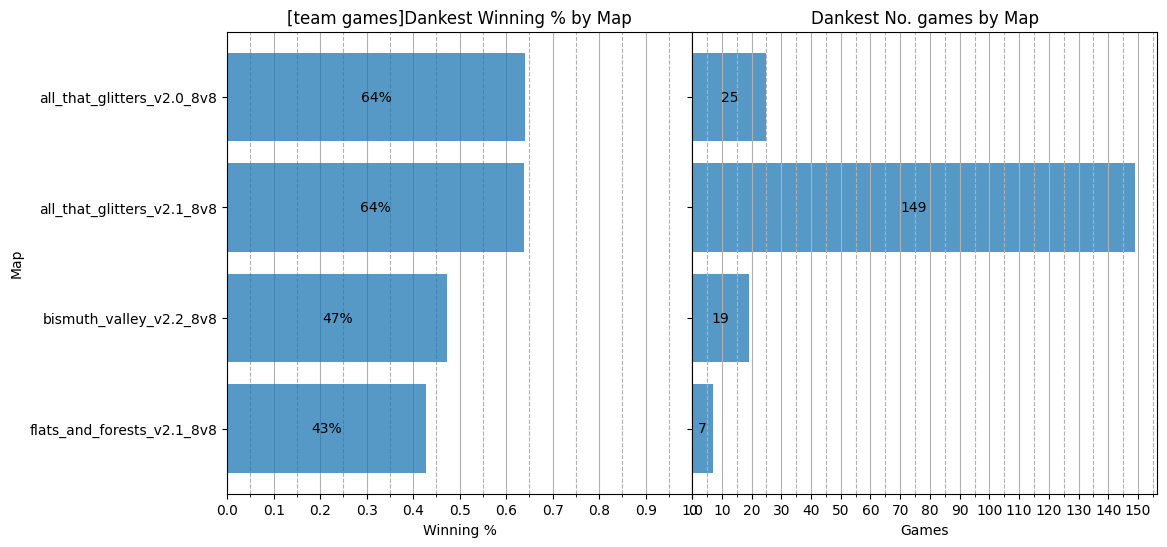

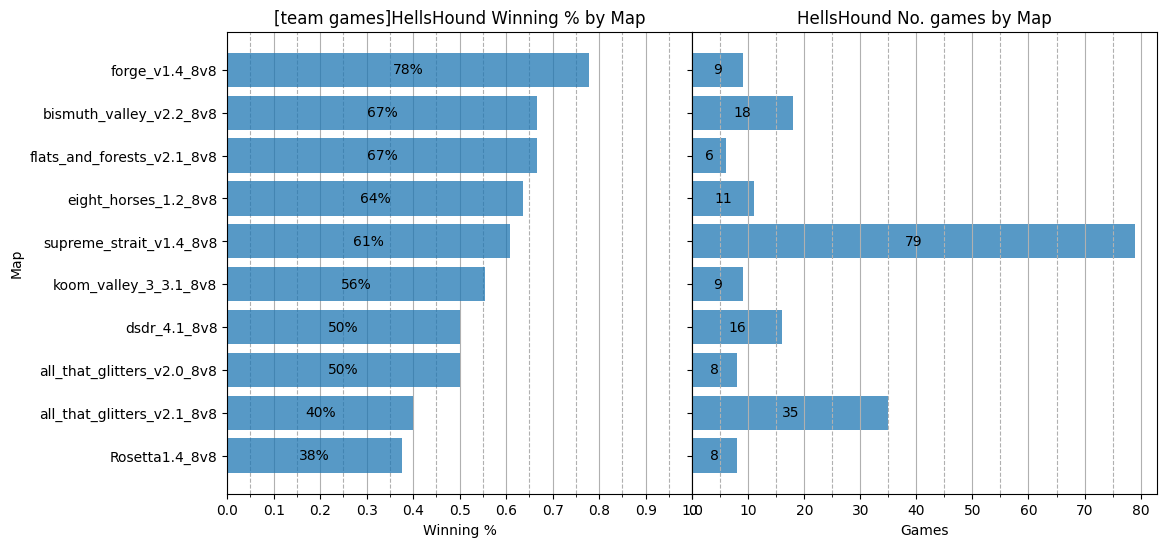

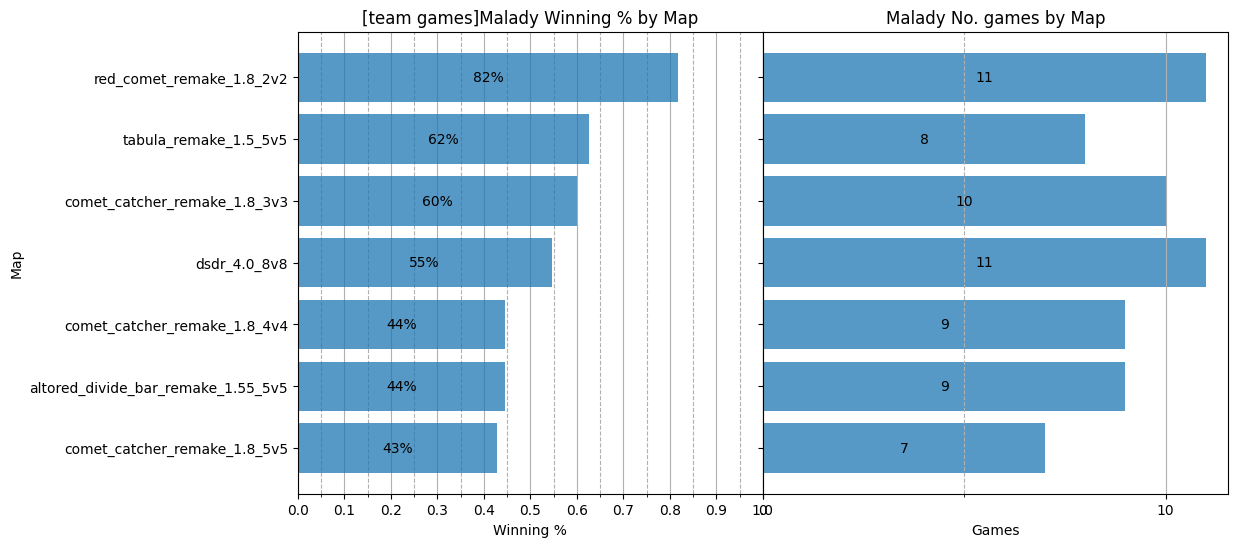

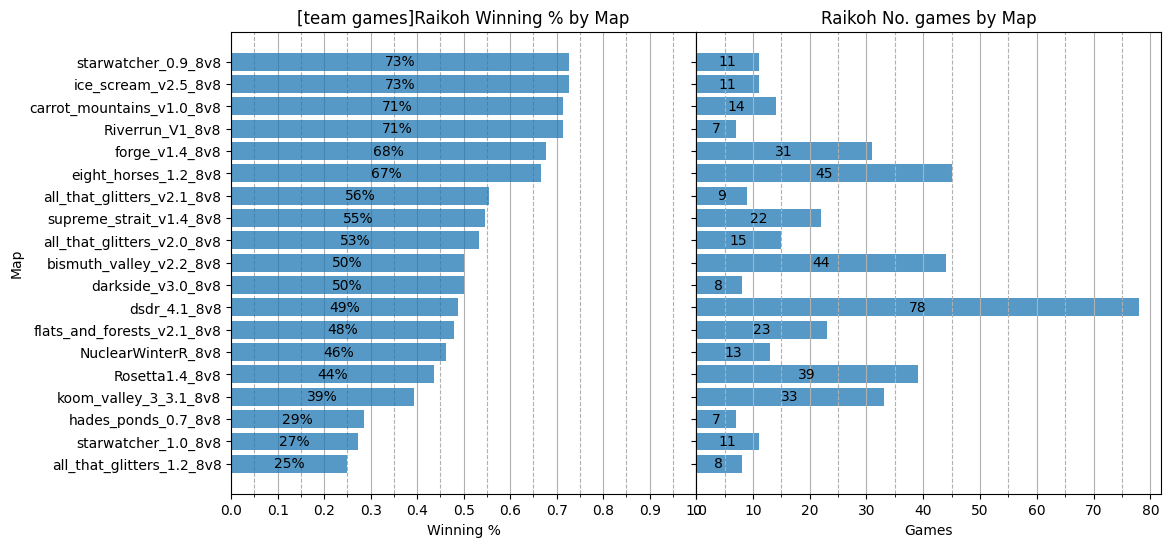

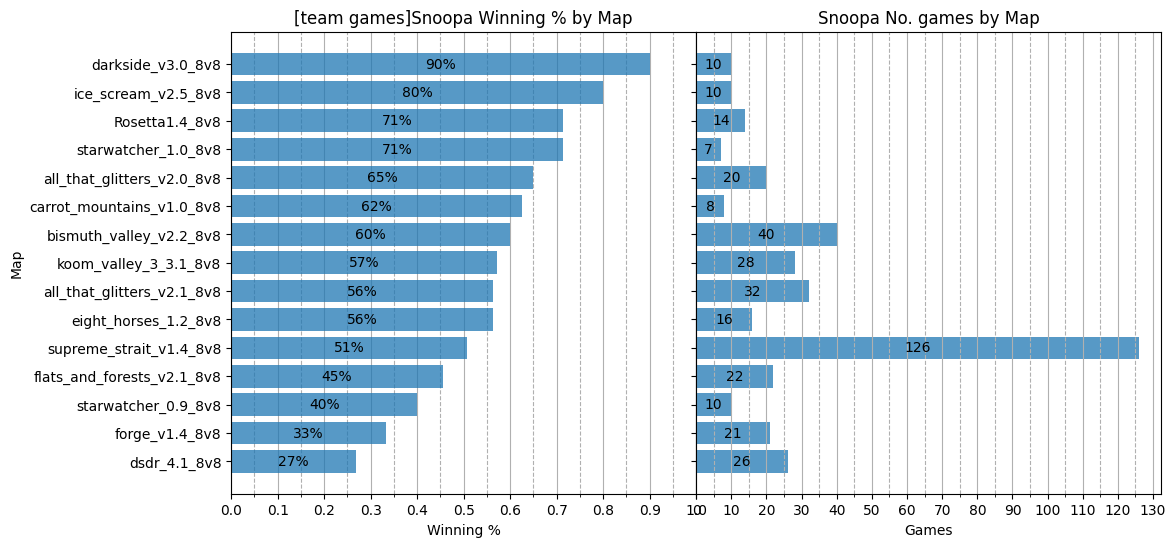

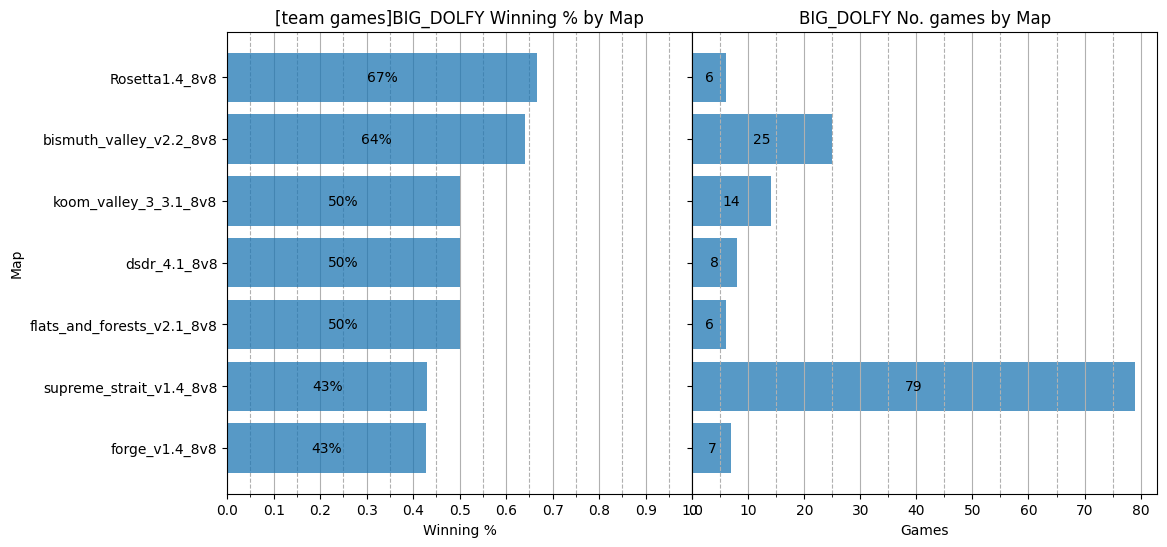

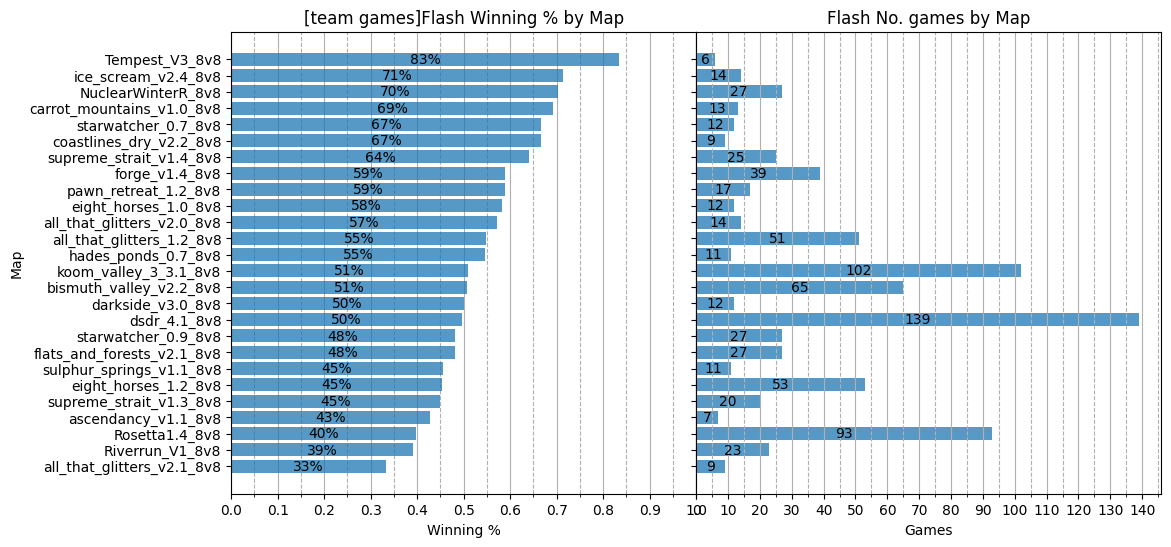

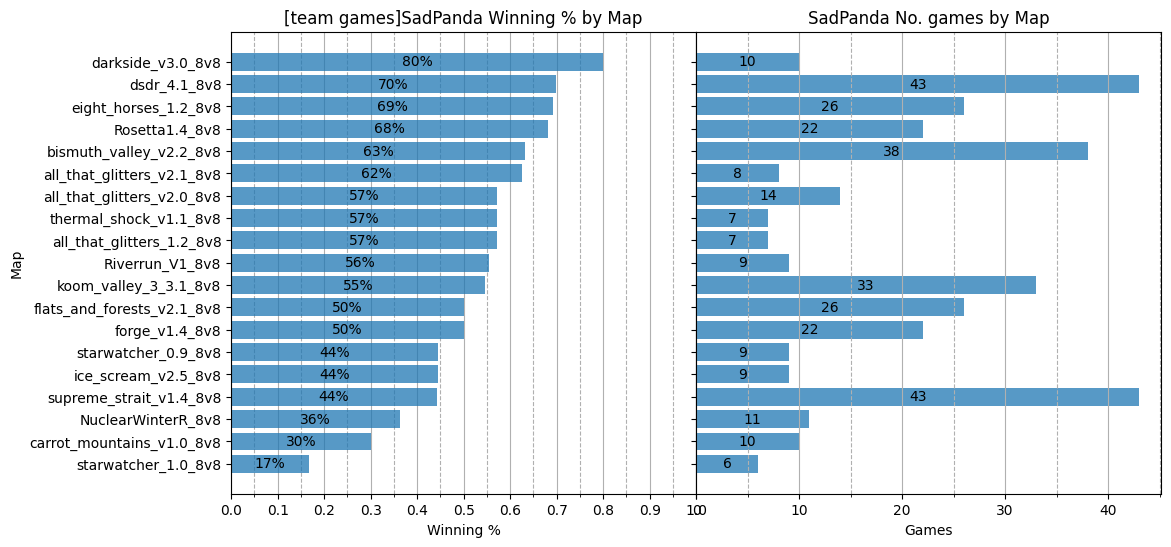

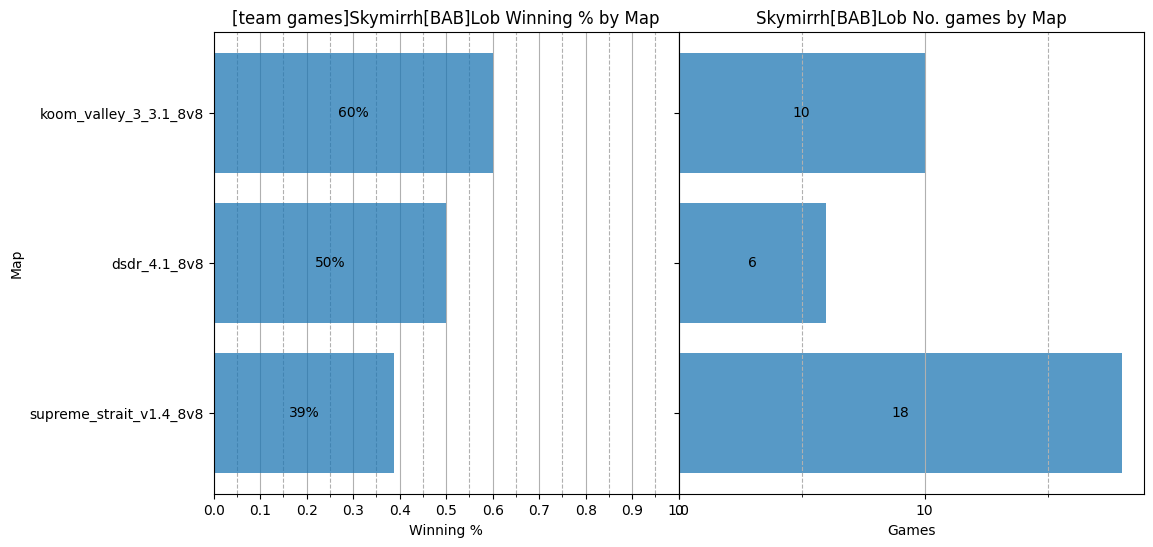

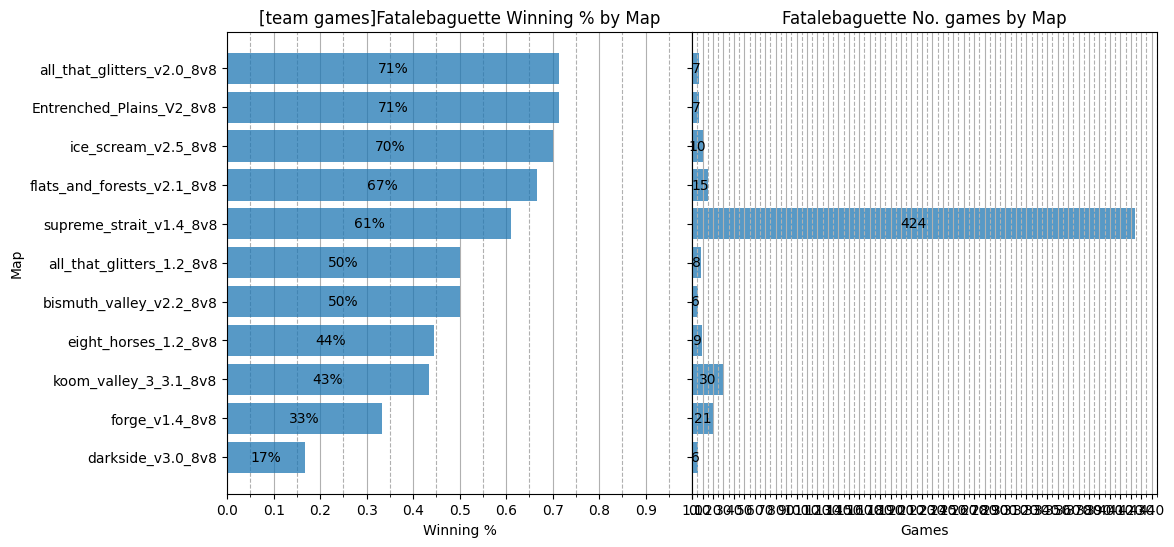

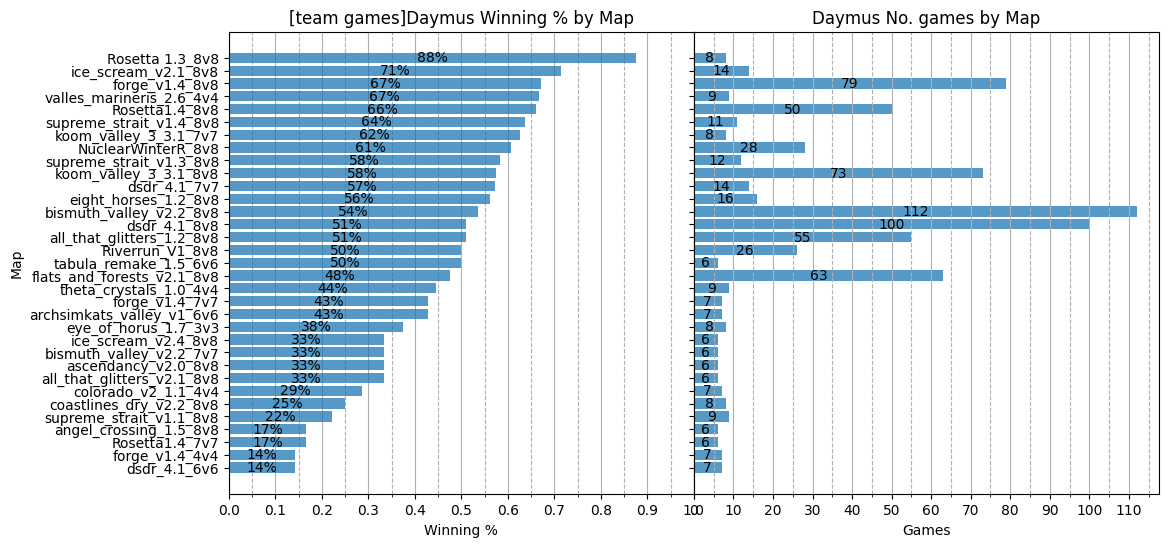

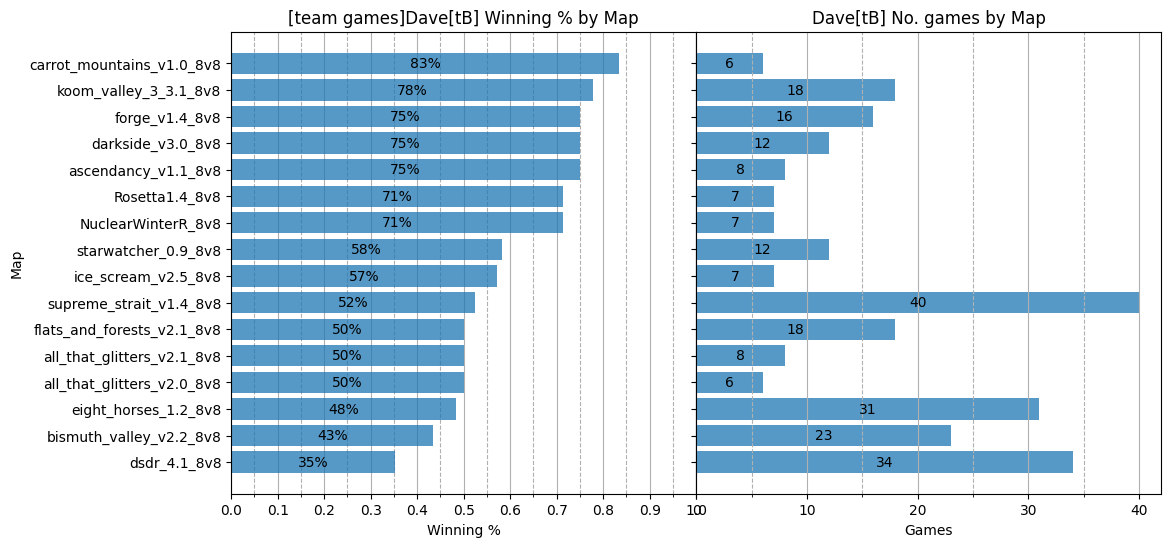

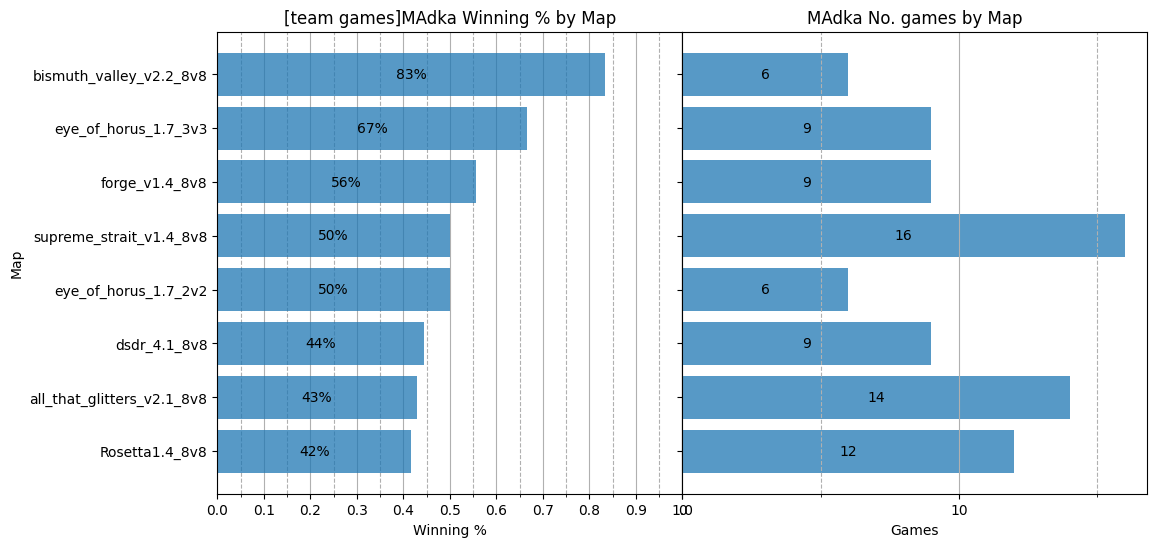

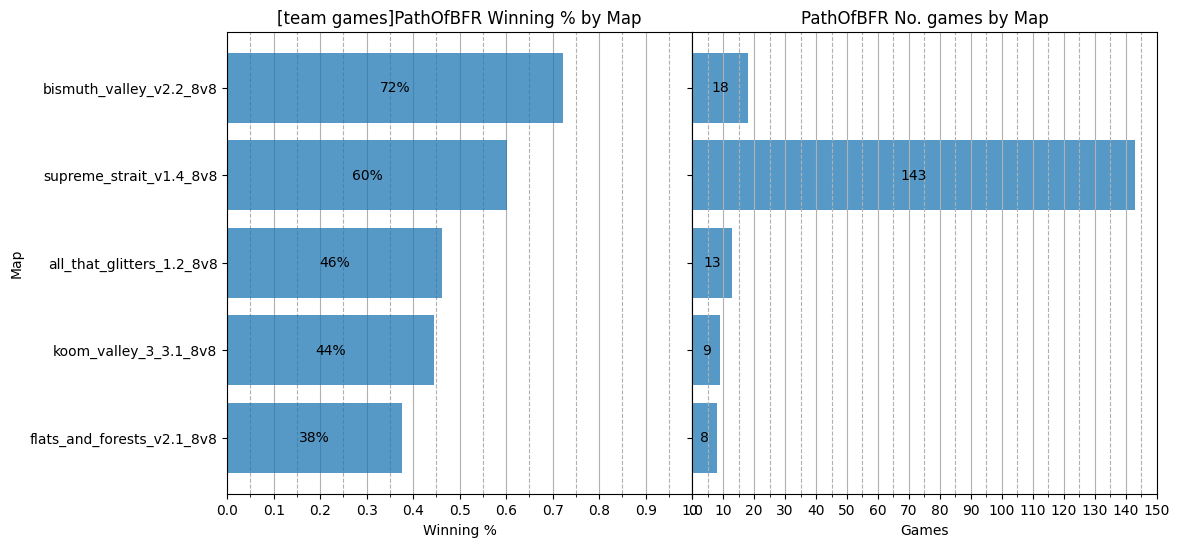

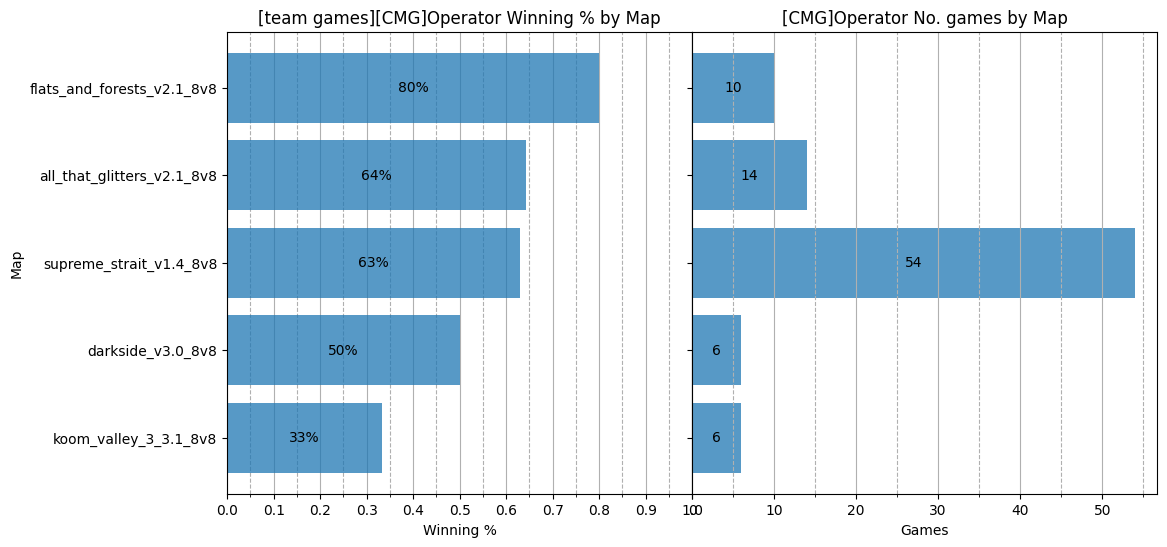

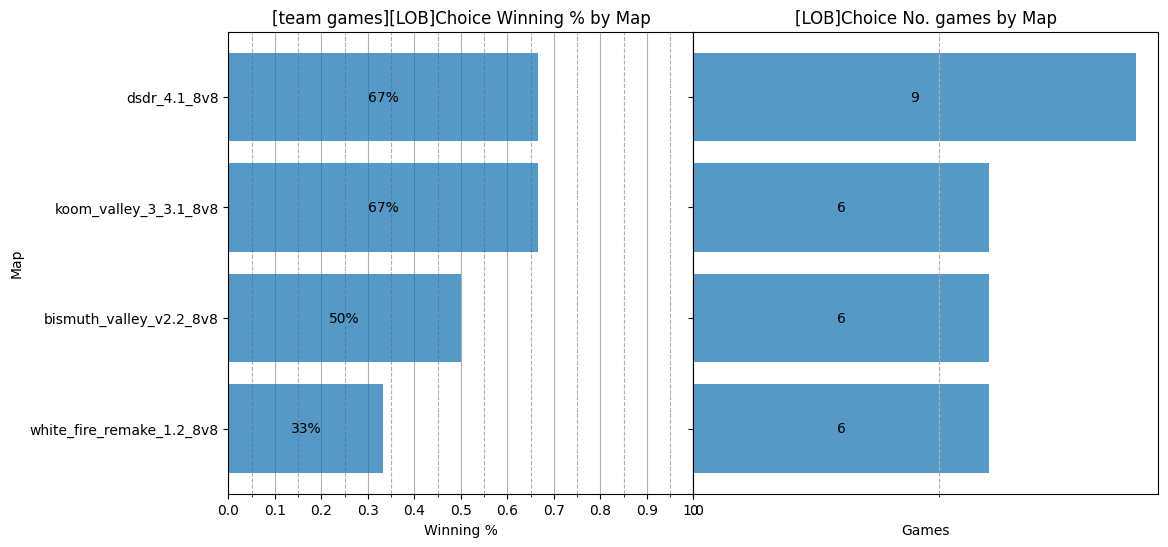

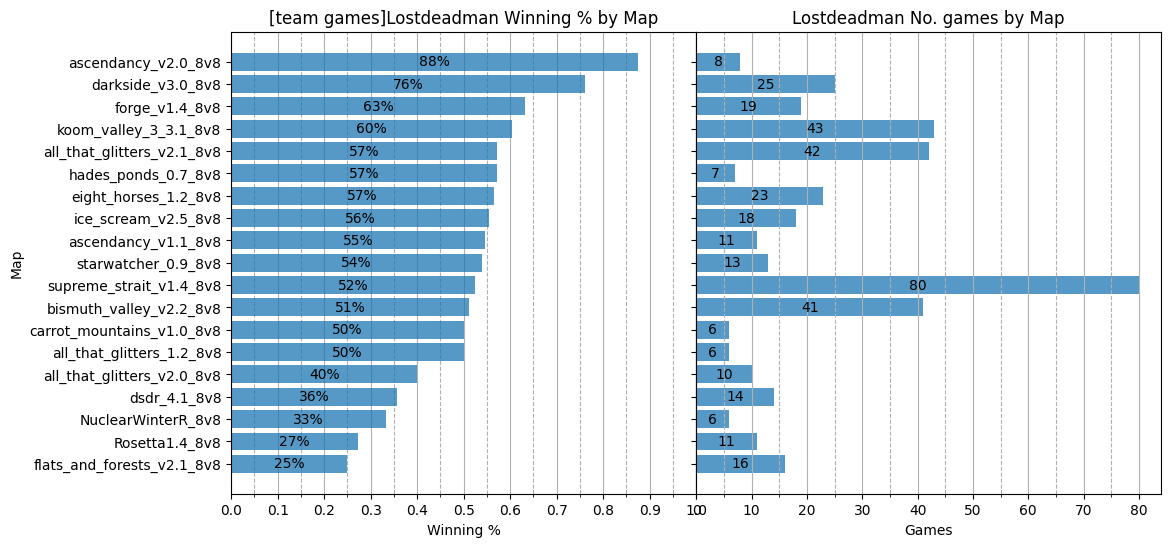

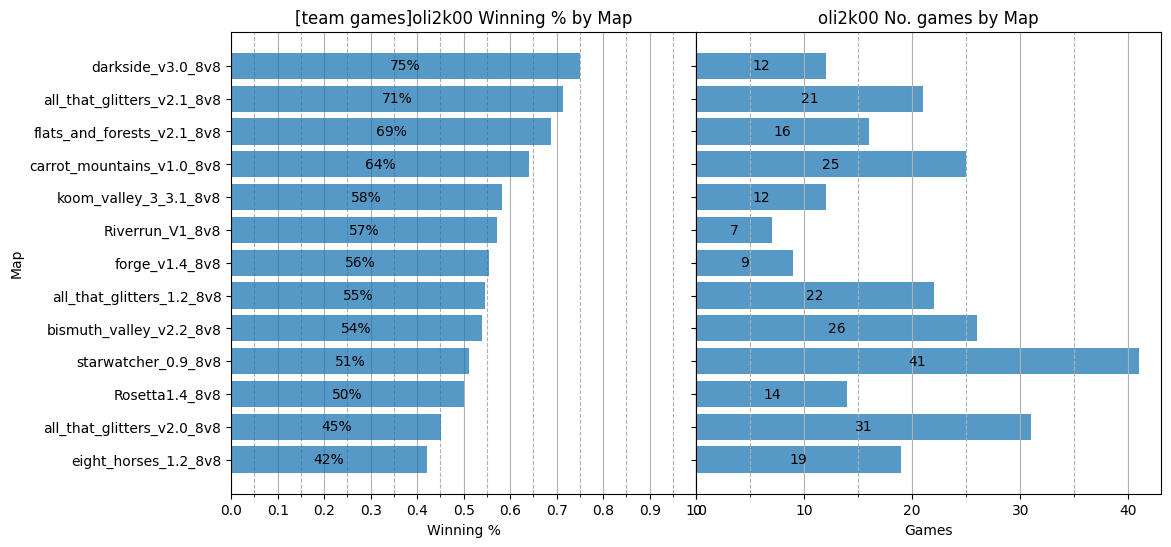

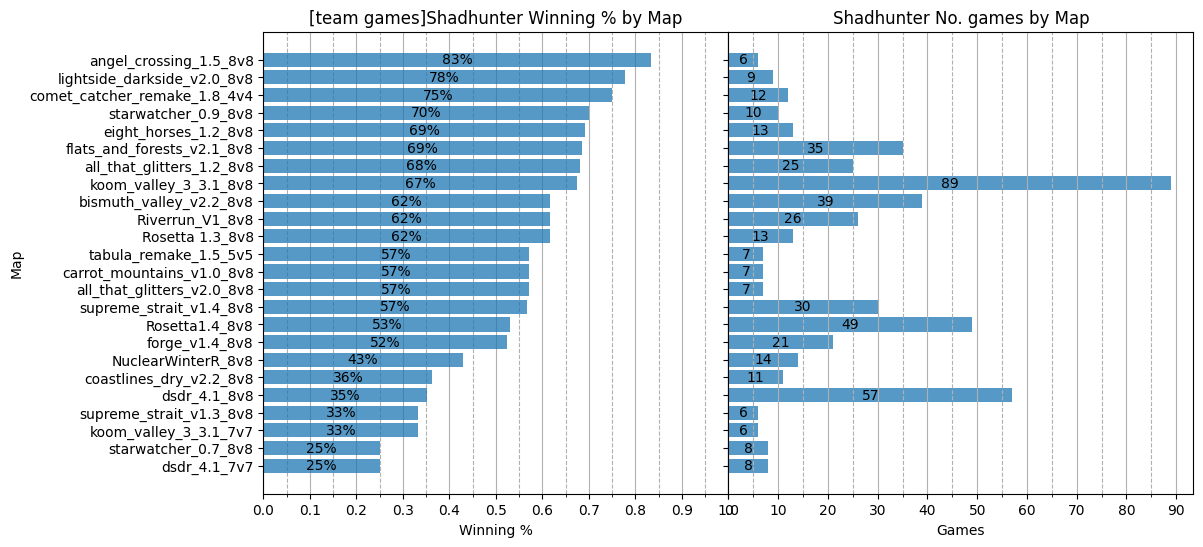

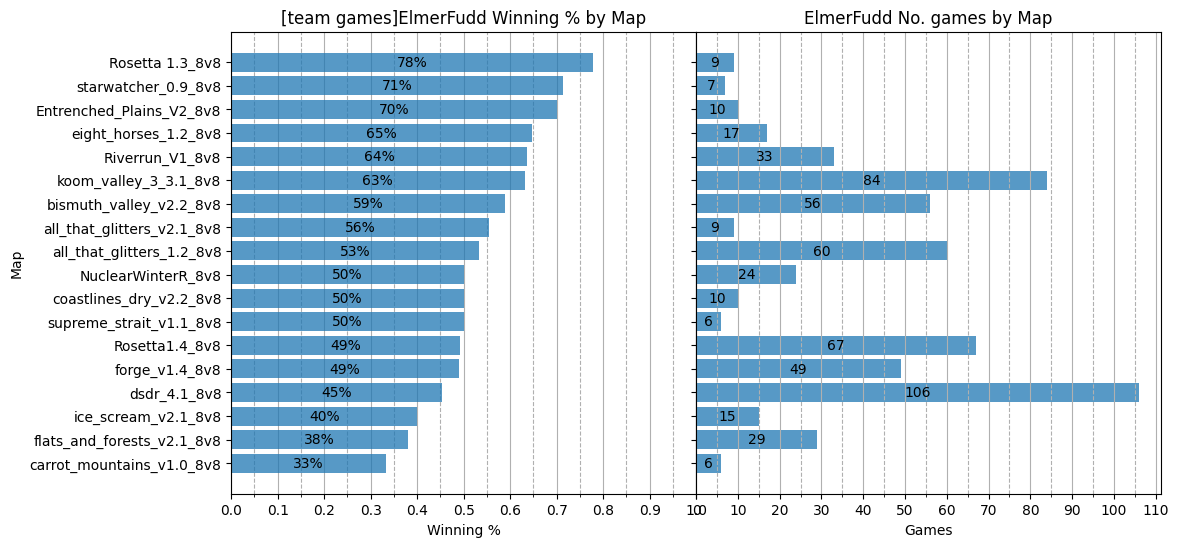

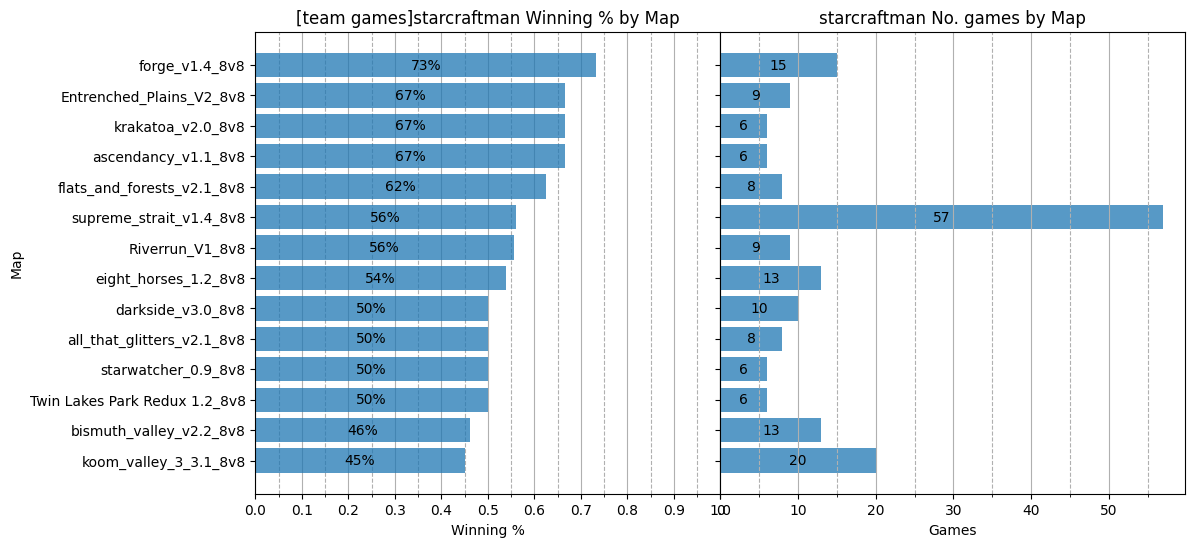

In [10]:
for user in team_leaderboards_df["name"]:
    matches_df = get_match_data(user, PRESET)
    # matches_df.to_csv(f"../data/{user}.csv")
    plot_win_rate(user)
plt.show()

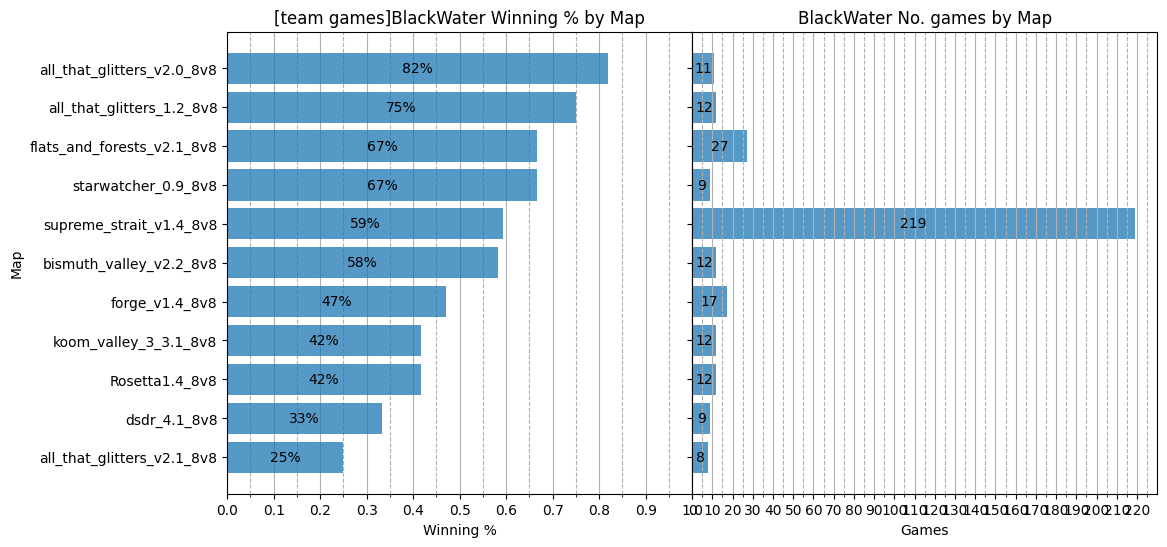

In [11]:
user = "BlackWater"

plot_win_rate(user)